**Step 1: Extract the Classified Dataset**

In [2]:
!unzip /content/drive/MyDrive/Dataset/data_classified.zip

Archive:  /content/drive/MyDrive/Dataset/data_classified.zip
   creating: data_classified/
   creating: data_classified/valid/
   creating: data_classified/train/
   creating: data_classified/valid/pitted_surface/
   creating: data_classified/valid/inclusion/
   creating: data_classified/valid/patches/
   creating: data_classified/valid/rolled-in_scale/
   creating: data_classified/valid/scratches/
   creating: data_classified/valid/crazing/
   creating: data_classified/train/pitted_surface/
   creating: data_classified/train/inclusion/
   creating: data_classified/train/patches/
   creating: data_classified/train/rolled-in_scale/
   creating: data_classified/train/scratches/
   creating: data_classified/train/crazing/
  inflating: data_classified/valid/pitted_surface/pitted_surface_5.jpg  
  inflating: __MACOSX/data_classified/valid/pitted_surface/._pitted_surface_5.jpg  
  inflating: data_classified/valid/pitted_surface/pitted_surface_4.jpg  
  inflating: __MACOSX/data_classified/val

**Step 2: Verify Train–Validation Split**

In [23]:
import glob
train_imgs = set(os.path.basename(p) for p in glob.glob('data_classified/train/*/*.jpg'))
valid_imgs = set(os.path.basename(p) for p in glob.glob('data_classified/valid/*/*.jpg'))
overlap = train_imgs & valid_imgs
print(f"Overlapping images between train and valid: {len(overlap)}")

Overlapping images between train and valid: 0


In [35]:
import tensorflow as tf

def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    """Custom Sparse Categorical Focal Loss (for imbalanced classification)."""
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        ce = -y_true_one_hot * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_sum(fl, axis=-1)
    return loss


📂 Loading datasets...
Found 1770 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
✅ Found 6 classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
⚖️ Computing class weights...
✅ Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}
🚀 Building model (MobileNetV3Large)...
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🧠 Compiling model for Stage 1 training...
🚦 Starting Stage 1 training (Feature Extraction)...
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.4451 - loss: 0.2684 - val_accuracy: 0.8000 - val_loss: 0.0971
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8422 - loss: 0.0589 - val_accuracy: 0.9000 - val_loss: 0.0439
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8947 - loss: 0.0363 - val_accuracy: 0.9667 - val_loss: 0.0262
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accur

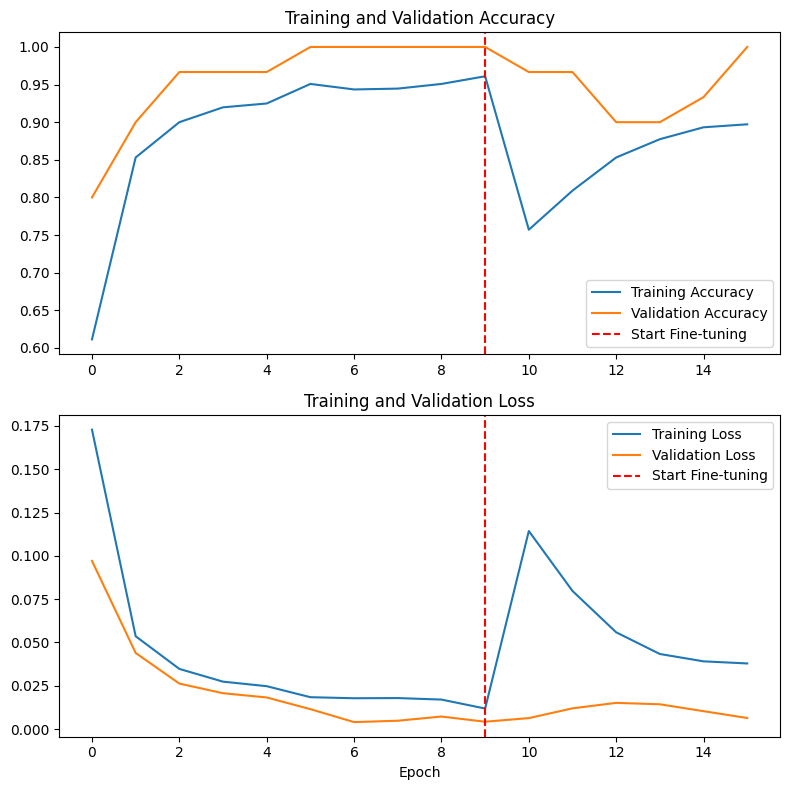

💾 Saving model...
✅ Model saved as 'my_defect_classifier_mobilenetv3.keras'


In [36]:
import glob, os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = 'data_classified'
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5

print("📂 Loading datasets...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
valid_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"✅ Found {num_classes} classes: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(AUTOTUNE)

print("⚖️ Computing class weights...")

# Convert all labels to numpy array safely
y_labels = []
for _, y in train_dataset.unbatch():
    y_labels.append(y.numpy())
y_labels = np.array(y_labels)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights = dict(enumerate(class_weights_array))
print("✅ Class weights:", class_weights)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

print("🚀 Building model (MobileNetV3Large)...")

base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet"
)
base_model.trainable = False  # freeze base initially

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

print("🧠 Compiling model for Stage 1 training...")

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INITIAL_LR,
    decay_steps=1000,
    alpha=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = sparse_categorical_focal_loss(gamma=2.0, alpha=0.25)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('mobilenetv3_best.keras', save_best_only=True)
]

print("🚦 Starting Stage 1 training (Feature Extraction)...")
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

print("🔧 Starting Stage 2 fine-tuning...")
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
print(f"✅ Unfreezing top {len(base_model.layers) - fine_tune_at} layers for fine-tuning...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss=loss_fn,
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=callbacks
)

print("📊 Plotting results...")

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

print("💾 Saving model...")
model.save("my_defect_classifier_mobilenetv3.keras")
print("✅ Model saved as 'my_defect_classifier_mobilenetv3.keras'")


Loading saved model...
Model is trained to predict: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Loading test image: data_classified/valid/scratches/scratches_5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Prediction Probabilities ---
crazing             : 0.00%
inclusion           : 0.02%
patches             : 0.01%
pitted_surface      : 0.00%
rolled-in_scale     : 0.00%
scratches           : 99.97%

--- Final Prediction ---
Predicted: scratches
Confidence: 99.97%


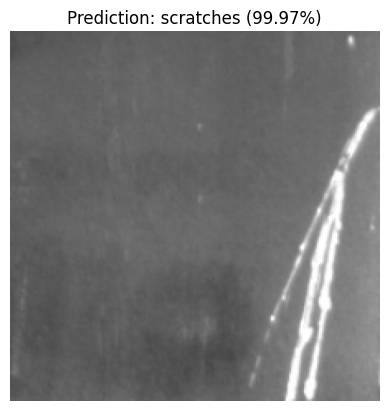

In [41]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os

print("Loading saved model...")

loaded_model = tf.keras.models.load_model(
    "my_defect_classifier_mobilenetv3.keras",
    compile=False
)

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
print(f"Model is trained to predict: {class_names}")

try:
    image_path = glob.glob("data_classified/valid/scratches/*.jpg")[0]

    #image_path = "/content/images-8.jpeg"
    print(f"Loading test image: {image_path}")

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = np.expand_dims(img, axis=0).astype(np.float32)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    predictions = loaded_model.predict(img_array)
    probs = predictions[0]
    predicted_class = class_names[np.argmax(probs)]
    confidence = 100 * np.max(probs)

    print("\n--- Prediction Probabilities ---")
    for cls, prob in zip(class_names, probs):
        print(f"{cls:20s}: {prob*100:.2f}%")

    print("\n--- Final Prediction ---")
    print(f"Predicted: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

except Exception as e:
    print(f"Error loading or predicting image: {e}")
